# Industry Segmentation Analysis

The ~170k companies from the Census that matched (more or less) Data Axle records provide a glimpse into how the industry is segmented, using NAICS and SIC codes. Though there are too many individual codes here to focus directly on each, both sets of codes are hierarchical, meaning we can drill through the industry hierarchies.

## Load Data

In [1]:
import polars as pl

df = pl.read_parquet("../data/fully_joined_census_and_data_axle.parquet")

print(f"Raw df shape: {df.shape}")

df = df.filter(pl.col("best_similarity_name_score") > 0.8) # Rely on close name matches only.

print(f"Filtered shape: {df.shape}")

Raw df shape: (2091643, 110)
Filtered shape: (173035, 110)


## Understand Industry Codes

The NAICS data come from [NAICS itself](https://www.naics.com/search/).

In [2]:
df = df.with_columns([
    pl.col("primary_naics_code").cast(str).alias("naics"),
    pl.col("naics8_descriptions").alias("naics_desc"),
    pl.col("primary_sic_code").cast(str).alias("sic"),
    pl.col("sic6_descriptions").alias("sic_desc")
])

In [3]:
df = df.with_columns([
    pl.col("primary_naics_code").cast(str).str.slice(0, 2).alias("naics2"),
    pl.col("primary_naics_code").cast(str).str.slice(0, 3).alias("naics3"),
])

In [4]:
naics = pl.read_csv("../data/naics-2022.csv", infer_schema_length=10000,
    schema_overrides={
        "2022 NAICS US   Code": pl.Utf8, 
        "2022 NAICS US Title": pl.Utf8,
    }).rename({
    "2022 NAICS US   Code": "code",
    '2022 NAICS US Title': "title",
    "Description": "description"
}).drop("Seq. No.")

In [5]:
naics2_lookup = (
    naics
    .with_columns(
        pl.col("code").str.slice(0, 2).alias("naics2")
    )
    .group_by("naics2")
    .agg(
        pl.col("title").first().alias("naics2_title")
    )
    .with_columns(
        pl.col("naics2_title").str.replace(r"T$", "").alias("naics2_title")
    )
)

In [6]:
df = (
    df
    .join(
        naics.select(["code", "title"]).rename({"code": "naics", "title": "naics_title"}),
        on="naics",
        how="left"
    )
    .join(
        naics.select(["code", "title"]).rename({"code": "naics2", "title": "naics2_title"}),
        on="naics2",
        how="left"
    )
    .join(
        naics.select(["code", "title"]).rename({"code": "naics3", "title": "naics3_title"}),
        on="naics3",
        how="left"
    )
)

In [7]:
industry_summary = (
    df
    .with_columns(pl.col("primary_naics_code").cast(str).str.slice(0, 2).alias("naics2"))
    .group_by("naics2")
    .agg(pl.len().alias("n"))
    .join(naics2_lookup, on="naics2", how="left")
    .with_columns(
        (pl.col("n") / pl.col("n").sum() * 100).alias("pct")
    )
    .sort("pct", descending=True)
)
industry_summary.head(10)

naics2,n,naics2_title,pct
str,u32,str,f64
"""23""",43701,"""Construction""",25.255584
"""48""",22817,"""Transportation and Warehousing""",13.18635
"""42""",16098,"""Wholesale Trade""",9.30332
"""44""",15679,"""Retail Trade""",9.061173
"""56""",15319,"""Administrative and Support and…",8.853122
"""81""",11366,"""Other Services (except Public …",6.568613
"""33""",9974,"""Primary Metal Manufacturing""",5.764152
"""54""",6905,"""Professional, Scientific, and …",3.990522
"""99""",4663,null,2.694831


## Find Correlations

In [8]:
operational_cols = [
    "NBR_POWER_UNIT",
    "DRIVER_TOTAL",
    "MCS150_MILEAGE",
    "MCS150_MILEAGE_YEAR",
    "RECENT_MILEAGE",
    "RECENT_MILEAGE_YEAR",
    "PRIVATE_ONLY",
    "AUTHORIZED_FOR_HIRE",
    "EXEMPT_FOR_HIRE",
    "PRIVATE_PROPERTY",
    "PRIVATE_PASSENGER_BUSINESS",
    "PRIVATE_PASSENGER_NONBUSINESS",
    "MIGRANT",
    "US_MAIL",
    "FEDERAL_GOVERNMENT",
    "STATE_GOVERNMENT",
    "LOCAL_GOVERNMENT",
    "INDIAN_TRIBE",
]

In [9]:
business_cols = [
    "employee_size_location",
    "sales_volume_location",
    "parent_actual_employee_size",
    "parent_actual_sales_volume",
    "naics2",
    "naics3",
]

In [10]:
all_cols = operational_cols + business_cols

corr_exprs = [
    [pl.corr(col, other_col).alias(f"{col}__{other_col}") for other_col in all_cols]
    for col in all_cols
]

flat_exprs = [expr for sublist in corr_exprs for expr in sublist]

corr_df = df.select(flat_exprs)

corr_matrix = pl.DataFrame(
    {col: corr_df.select([c for c in corr_df.columns if c.startswith(col + "__")]).row(0) 
     for col in all_cols}
)

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


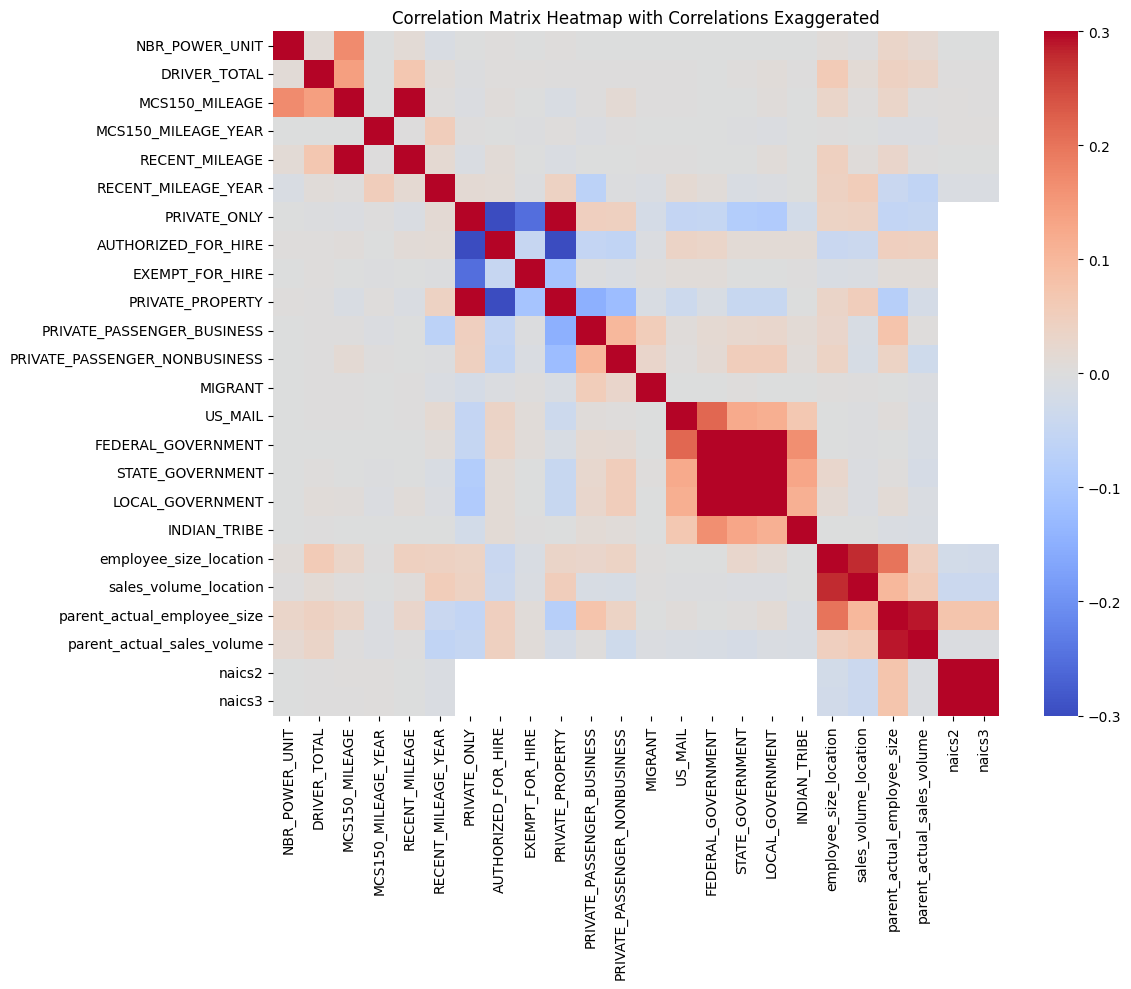

In [12]:
corr_array = corr_matrix.to_numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_array, xticklabels=all_cols, yticklabels=all_cols,
            cmap="coolwarm", center=0, annot=False, vmin=-0.3, vmax=0.3)
plt.title("Correlation Matrix Heatmap with Correlations Exaggerated")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
df = df.with_columns(pl.col("naics2").cast(pl.Categorical))

In [14]:
df_clean = df.filter(pl.col("naics2").is_not_null())
naics_dummies = df_clean["naics2"].to_dummies(separator="_", drop_first=False)

naics_mapping = dict(zip(naics2_lookup["naics2"].to_list(), naics2_lookup["naics2_title"].to_list()))

naics_renamed = naics_dummies.rename({
    f"naics2_{code}": naics_mapping[code]
    for code in naics_mapping
    if f"naics2_{code}" in naics_dummies.columns
})

gov_df = df_clean.select(operational_cols)

corr_exprs = [
    [pl.corr(naics_col, gov_col).alias(f"{naics_col}__{gov_col}")
     for gov_col in operational_cols]
    for naics_col in naics_renamed.columns
]

flat_exprs = [expr for sublist in corr_exprs for expr in sublist]

corr_df = pl.concat([naics_renamed, gov_df], how="horizontal").select(flat_exprs)

corr_matrix = pl.DataFrame({
    gov_col: corr_df.select([c for c in corr_df.columns if c.endswith(f"__{gov_col}")]).row(0)
    for gov_col in operational_cols
})

corr_matrix = corr_matrix.with_columns(pl.Series("industry", naics_renamed.columns)).select(["industry"] + operational_cols)

print(corr_matrix)

shape: (25, 19)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ industry  ┆ NBR_POWER ┆ DRIVER_TO ┆ MCS150_MI ┆ … ┆ FEDERAL_G ┆ STATE_GOV ┆ LOCAL_GOV ┆ INDIAN_T │
│ ---       ┆ _UNIT     ┆ TAL       ┆ LEAGE     ┆   ┆ OVERNMENT ┆ ERNMENT   ┆ ERNMENT   ┆ RIBE     │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Agricultu ┆ -0.000664 ┆ -0.001764 ┆ -0.00157  ┆ … ┆ 0.014972  ┆ -0.002296 ┆ -0.00522  ┆ 0.003039 │
│ re,       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Forestry, ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Fishing…  ┆           ┆           ┆           ┆   ┆           ┆          

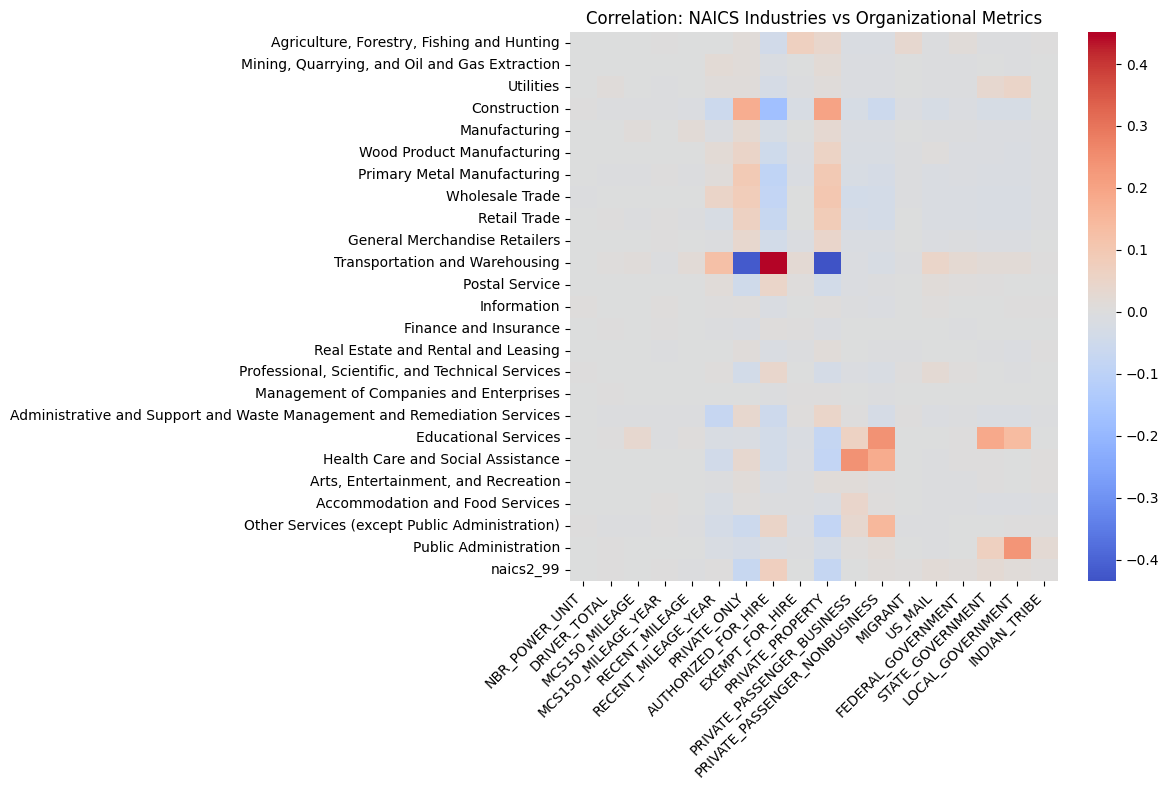

In [15]:
heatmap_data = corr_matrix.select(operational_cols).to_numpy()

row_labels = corr_matrix["industry"].to_list()

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    xticklabels=operational_cols,
    yticklabels=row_labels,
    cmap="coolwarm",
    center=0
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Correlation: NAICS Industries vs Organizational Metrics")
plt.tight_layout()
plt.show()